In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/shopee-code-league-2020-sentiment-analysis/clean_extended_train.csv
/kaggle/input/shopee-code-league-2020-sentiment-analysis/clean_test_up.csv
/kaggle/input/shopee-sentiment-analysis/test.csv
/kaggle/input/shopee-sentiment-analysis/train.csv
/kaggle/input/shopee-sentiment-analysis/sampleSubmission.csv
/kaggle/input/test-labelled/test_labelled.csv
/kaggle/input/shopee-reviews/shopee_reviews.csv


**Load data**

In [2]:
train_df = pd.read_csv('../input/shopee-sentiment-analysis/train.csv')
test_df = pd.read_csv('../input/shopee-sentiment-analysis/test.csv')
print(train_df.shape, test_df.shape)

(146811, 3) (60427, 2)


# EDA

In [3]:
train_df.head()

,review_id,review,rating
0,0,Ga disappointed neat products .. Meletot Hilsn...,1
1,1,"Rdtanya replace broken glass, broken chargernya",1
2,2,Nyesel bngt dsni shopping antecedent photo mes...,1
3,3,Sent a light blue suit goods ga want a refund,1
4,4,Pendants came with dents and scratches on its ...,1


In [4]:
test_df.head()

,review_id,review
0,1,"Great danger, cool, motif and cantik2 jg model..."
1,2,One of the shades don't fit well
2,3,Very comfortable
3,4,Fast delivery. Product expiry is on Dec 2022. ...
4,5,it's sooooo cute! i like playing with the glit...


**Check for duplicate reviews**

In [5]:
dup_df = train_df[train_df['review'].duplicated()]
print(f'No. of duplicate reviews on train data: {dup_df.shape[0]}')

No. of duplicate reviews on train data: 31483


Check if the duplicate reviews have the same rating

In [6]:
dup_df['check'] = dup_df.apply(lambda x: str(x.review) + str(x.rating), axis = 1)
print(dup_df['check'].duplicated().sum(),'of duplicate reviews have the same rating')

28523 of duplicate reviews have the same rating


Since most of the duplicate reviews have the same rating, we could choose to drop them

In [7]:
train_df.drop_duplicates(subset = 'review', inplace = True)

**Rating statistics**

In [8]:
train_df['rating'].value_counts()

4    31640
5    30413
3    28288
1    13807
2    11180
Name: rating, dtype: int64

In [9]:
count_df = train_df.groupby(['rating']).count()
count_df.drop(['review_id'], axis = 1, inplace = True)
count_df['percentage'] = 100 * count_df['review']  / count_df['review'].sum()
count_df

,review,percentage
rating,,
1,13807,11.971941
2,11180,9.694090
3,28288,24.528302
4,31640,27.434795
5,30413,26.370873


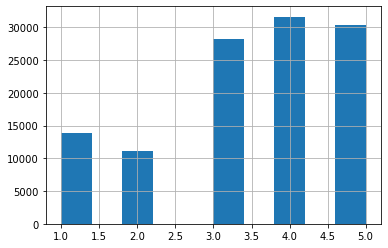

In [10]:
train_df['rating'].hist()

**Length statistics**

In [11]:
from nltk import word_tokenize

def count_len(text):
    return len(word_tokenize(text))

In [12]:
train_df['len'] = train_df['review'].apply(count_len)
test_df['len'] = test_df['review'].apply(count_len)

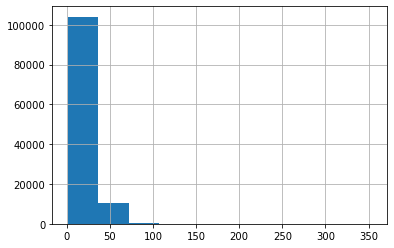

In [13]:
train_df['len'].hist()

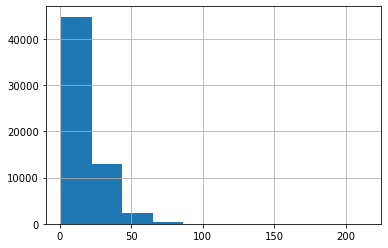

In [14]:
test_df['len'].hist()

Looking at the histogram, a length of 100 is enough to cover most (more than 90 pecent) of the data

**Extend train data with publicly, freely available external data**

In [15]:
# kaggle.com/liuhh02/test-labelled
# old test leak labelled
test_labelled = pd.read_csv('../input/test-labelled/test_labelled.csv')
test_labelled

,review_id,review,rating
0,0,slow delivery,1
1,1,Dateng goods do not conform pesanan😔,1
2,2,PSN k its 20 other DTG,1
3,3,I am expected that it have a frame and painted...,1
4,4,The product quality is not good.,1
...,...,...,...
62913,62913,Has shipped It was the model that fits the cut...,5
62914,62914,Awesome awesome speed of the ship's value CP,5
62915,62915,but already in lebihin one of its usual size w...,5
62916,62916,The product quality is excellent.,5


In [16]:
dup_testlab = test_labelled[test_labelled['review'].duplicated()]
print(f'No. of duplicate reviews: {dup_testlab.shape[0]}')
dup_testlab['check'] = dup_testlab.apply(lambda x: str(x.review) + str(x.rating), axis = 1)
print(dup_testlab['check'].duplicated().sum(),'of duplicate reviews have the same rating')

No. of duplicate reviews: 13040
11667 of duplicate reviews have the same rating


In [17]:
test_labelled.drop_duplicates(subset = 'review', inplace = True)

In [18]:
# kaggle.com/shymammoth/shopee-reviews
# scraped shopee reviews
scraped_reviews = pd.read_csv('../input/shopee-reviews/shopee_reviews.csv')
scraped_reviews

,label,text
0,5,Looks ok. Not like so durable. Will hv to use ...
1,5,"Tried, the current can be very powerful depend..."
2,5,Item received after a week. Looks smaller than...
3,5,Thanks!!! Works as describe no complaints. Not...
4,5,Fast delivery considering it’s from overseas a...
...,...,...
1502570,5,Tried and it fit nicely will buy \nFast and go...
1502571,5,It's a fantastic product. Very reasonable pric...
1502572,5,Nice pair of shoes for a gd price. Note the cu...
1502573,1,Leather? Rubbish....moulded plastic. What a ...


Change column names for merging

In [19]:
scraped_reviews.rename(columns = {'text': 'review', 'label': 'rating'}, inplace = True)
scraped_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1502575 entries, 0 to 1502574
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   rating  1502575 non-null  object
 1   review  1502575 non-null  object
dtypes: object(2)
memory usage: 22.9+ MB


In [20]:
scraped_reviews['rating'].value_counts()

5        1137695
5         166237
4          88686
3          42911
1          24704
2          16724
4          13443
3           6172
1           3650
2           2352
label          1
Name: rating, dtype: int64

In [21]:
scraped_reviews = scraped_reviews[scraped_reviews['rating'] != 'label']
scraped_reviews['rating'] = scraped_reviews['rating'].astype(int)
scraped_reviews['rating'].value_counts()

5    1303932
4     102129
3      49083
1      28354
2      19076
Name: rating, dtype: int64

In [22]:
dup_scraped = scraped_reviews[scraped_reviews['review'].duplicated()]
print(f'No. of duplicate reviews: {dup_scraped.shape[0]}')

No. of duplicate reviews: 0


In [23]:
train_df = train_df.append(test_labelled, ignore_index = True)
train_df = train_df.append(scraped_reviews, ignore_index = True)
train_df = train_df.sample(frac = 1).reset_index(drop = True)

Final check for duplicates

In [24]:
dup_train = train_df[train_df['review'].duplicated()]
print(f'No. of duplicate reviews on train data: {dup_train.shape[0]}')
dup_train['check'] = dup_train.apply(lambda x: str(x.review) + str(x.rating), axis = 1)
print(dup_train['check'].duplicated().sum(),'of duplicate reviews have the same rating')

No. of duplicate reviews on train data: 33166
179 of duplicate reviews have the same rating


In [25]:
train_df

,review_id,review,rating,len
0,NaN,love how soft the material is! will get more f...,5,NaN
1,NaN,Rly love the material of the mask!!! Soft & co...,5,NaN
2,NaN,Smooth delivery. The shirt was so comfy ! I lo...,5,NaN
3,NaN,"item received, well pack. yet try. thanks se...",5,NaN
4,NaN,Received in a week upon ordering. Received in ...,5,NaN
...,...,...,...,...
1667775,NaN,authentic! was able to verify serial number on...,5,NaN
1667776,NaN,Ordered on 17 Jun and received on 24 Jun. Box ...,5,NaN
1667777,NaN,Received promptly and pack nicely in carton. G...,5,NaN
1667778,NaN,"Looks not bad, delivery take quite sometimes b...",5,NaN


# Data Preprocessing

In [26]:
train_df['rating'].value_counts()

5    1347428
4     147498
3      89644
1      48145
2      35065
Name: rating, dtype: int64

Trim train set by half to minimize training time

In [27]:
train_df = train_df.drop(train_df[train_df['rating'] == 5].sample(frac = .6).index)
print(train_df['rating'].value_counts())
print(train_df.shape)

5    538971
4    147498
3     89644
1     48145
2     35065
Name: rating, dtype: int64
(859323, 4)


**Data cleaning**

Join train and test for cleaning

In [28]:
# adding column 'rating' to test dataset
test_df['rating'] = -1 # flag to separate train and test

# joining train and test datasets
reviews = pd.concat([train_df, test_df], ignore_index = True)
reviews

,review_id,review,rating,len
0,NaN,"item received, well pack. yet try. thanks se...",5,NaN
1,NaN,Received in a week upon ordering. Received in ...,5,NaN
2,NaN,Colour doesn’t come out as strong as it should...,4,NaN
3,NaN,The padding is not to my likings.,2,NaN
4,NaN,Very happy with my purchase ! Nice thx u,5,NaN
...,...,...,...,...
919745,60423.0,Product has been succesfully ordered and shipp...,-1,27.0
919746,60424.0,Opening time a little scared. Fear dalemnya de...,-1,18.0
919747,60425.0,The product quality is excellent. The origina...,-1,34.0
919748,60426.0,They 're holding up REALLY well also .,-1,8.0


In [29]:
from nltk.tokenize import word_tokenize
from nltk import FreqDist
from nltk.stem import SnowballStemmer, WordNetLemmatizer

stemmer = SnowballStemmer('english')
lemma = WordNetLemmatizer()

from string import punctuation

In [30]:
def clean_review(review_col):
    review_corpus=[]
    
    for i in range(0, len(review_col)):
        review = str(review_col[i])
        review = re.sub('[^a-zA-Z]', ' ', review)
        review = [lemma.lemmatize(w) for w in word_tokenize(str(review).lower())]
        review = ' '.join(review)
        
        review_corpus.append(review)
        
    return review_corpus

In [31]:
import emoji  

have_emoji_train_idx = []

for idx, review in enumerate(reviews['review']):
    if any(char in emoji.UNICODE_EMOJI for char in review):
        have_emoji_train_idx.append(idx)

In [32]:
def emoji_cleaning(text):
    
    # change emoji to text
    text = emoji.demojize(text).replace(":", " ")
    
    # delete repeated emoji
    tokenizer = text.split()
    repeated_list = []
    
    for word in tokenizer:
        if word not in repeated_list:
            repeated_list.append(word)
    
    text = ' '.join(text for text in repeated_list)
    text = text.replace("_", " ").replace("-", " ")
    return text

In [33]:
# emoji_cleaning
reviews.loc[have_emoji_train_idx, 'review'] = reviews.loc[have_emoji_train_idx, 'review'].apply(emoji_cleaning)

In [34]:
def review_cleaning(text):
    
    text = text.lower()
    text = re.sub(r'\n', '', text)
    
#     text = text.replace("n't", ' not')
    
    # change emoticon to text
    text = re.sub(r':\(', 'dislike', text)
    text = re.sub(r': \(\(', 'dislike', text)
    text = re.sub(r':, \(', 'dislike', text)
    text = re.sub(r':\)', 'smile', text)
    text = re.sub(r';\)', 'smile', text)
    text = re.sub(r':\)\)\)', 'smile', text)
    text = re.sub(r':\)\)\)\)\)\)', 'smile', text)
    text = re.sub(r'=\)\)\)\)', 'smile', text)
    
#     # delete punctuation
#     text = re.sub('[^a-z0-9 ]', ' ', text)
    
    tokenizer = text.split()
    
    return ' '.join([text for text in tokenizer])

In [35]:
reviews['review'] = reviews['review'].apply(review_cleaning)

In [36]:
repeated_rows_train = []

for idx, review in enumerate(reviews['review']):
    if re.match(r'\w*(\w)\1+', review):
        repeated_rows_train.append(idx)

In [37]:
def delete_repeated_char(text):
    
    text = re.sub(r'(\w)\1{2,}', r'\1', text)
    
    return text

In [38]:
reviews.loc[repeated_rows_train, 'review'] = reviews.loc[repeated_rows_train, 'review'].apply(delete_repeated_char)

In [39]:
def recover_shortened_words(text):
    
    text = re.sub(r'\bapaa\b', 'apa', text)
    
    text = re.sub(r'\bbsk\b', 'besok', text)
    text = re.sub(r'\bbrngnya\b', 'barangnya', text)
    text = re.sub(r'\bbrp\b', 'berapa', text)
    text = re.sub(r'\bbgt\b', 'banget', text)
    text = re.sub(r'\bbngt\b', 'banget', text)
    text = re.sub(r'\bgini\b', 'begini', text)
    text = re.sub(r'\bbrg\b', 'barang', text)
    
    text = re.sub(r'\bdtg\b', 'datang', text)
    text = re.sub(r'\bd\b', 'di', text)
    text = re.sub(r'\bsdh\b', 'sudah', text)
    text = re.sub(r'\bdri\b', 'dari', text)
    text = re.sub(r'\bdsni\b', 'disini', text)
    
    text = re.sub(r'\bgk\b', 'gak', text)
    
    text = re.sub(r'\bhrs\b', 'harus', text)
    
    text = re.sub(r'\bjd\b', 'jadi', text)
    text = re.sub(r'\bjg\b', 'juga', text)
    text = re.sub(r'\bjgn\b', 'jangan', text)
    
    text = re.sub(r'\blg\b', 'lagi', text)
    text = re.sub(r'\blgi\b', 'lagi', text)
    text = re.sub(r'\blbh\b', 'lebih', text)
    text = re.sub(r'\blbih\b', 'lebih', text)
    
    text = re.sub(r'\bmksh\b', 'makasih', text)
    text = re.sub(r'\bmna\b', 'mana', text)
    
    text = re.sub(r'\borg\b', 'orang', text)
    
    text = re.sub(r'\bpjg\b', 'panjang', text)
    
    text = re.sub(r'\bka\b', 'kakak', text)
    text = re.sub(r'\bkk\b', 'kakak', text)
    text = re.sub(r'\bklo\b', 'kalau', text)
    text = re.sub(r'\bkmrn\b', 'kemarin', text)
    text = re.sub(r'\bkmrin\b', 'kemarin', text)
    text = re.sub(r'\bknp\b', 'kenapa', text)
    text = re.sub(r'\bkcil\b', 'kecil', text)
    
    text = re.sub(r'\bgmn\b', 'gimana', text)
    text = re.sub(r'\bgmna\b', 'gimana', text)
    
    text = re.sub(r'\btp\b', 'tapi', text)
    text = re.sub(r'\btq\b', 'thanks', text)
    text = re.sub(r'\btks\b', 'thanks', text)
    text = re.sub(r'\btlg\b', 'tolong', text)
    text = re.sub(r'\bgk\b', 'tidak', text)
    text = re.sub(r'\bgak\b', 'tidak', text)
    text = re.sub(r'\bgpp\b', 'tidak apa apa', text)
    text = re.sub(r'\bgapapa\b', 'tidak apa apa', text)
    text = re.sub(r'\bga\b', 'tidak', text)
    text = re.sub(r'\btgl\b', 'tanggal', text)
    text = re.sub(r'\btggl\b', 'tanggal', text)
    text = re.sub(r'\bgamau\b', 'tidak mau', text)
    
    text = re.sub(r'\bsy\b', 'saya', text)
    text = re.sub(r'\bsis\b', 'sister', text)
    text = re.sub(r'\bsdgkan\b', 'sedangkan', text)
    text = re.sub(r'\bmdh2n\b', 'semoga', text)
    text = re.sub(r'\bsmoga\b', 'semoga', text)
    text = re.sub(r'\bsmpai\b', 'sampai', text)
    text = re.sub(r'\bnympe\b', 'sampai', text)
    text = re.sub(r'\bdah\b', 'sudah', text)
    
    text = re.sub(r'\bberkali2\b', 'repeated', text)
    
    text = re.sub(r'\byg\b', 'yang', text)
    
    return text

In [40]:
%%time
reviews['review'] = reviews['review'].apply(recover_shortened_words)

CPU times: user 4min 33s, sys: 78.8 ms, total: 4min 33s
Wall time: 4min 33s


In [41]:
# cleaning round 2, lemmatization
reviews['review'] = clean_review(reviews['review'].values)
reviews

,review_id,review,rating,len
0,NaN,item received well pack yet try thanks seller ...,5,NaN
1,NaN,received in a week upon ordering received in g...,5,NaN
2,NaN,colour doesn t come out a strong a it should be,4,NaN
3,NaN,the padding is not to my liking,2,NaN
4,NaN,very happy with my purchase nice thx u,5,NaN
...,...,...,...,...
919745,60423.0,product ha been succesfully ordered and shippe...,-1,27.0
919746,60424.0,opening time a little scared fear dalemnya des...,-1,18.0
919747,60425.0,the product quality is excellent the original ...,-1,34.0
919748,60426.0,they re holding up really well also,-1,8.0


**Separating train and test sets**

In [42]:
train_df = reviews[reviews.rating != -1]
train_df.drop(['review_id', 'len'], axis = 1, inplace = True)
train_df.head()

,review,rating
0,item received well pack yet try thanks seller ...,5
1,received in a week upon ordering received in g...,5
2,colour doesn t come out a strong a it should be,4
3,the padding is not to my liking,2
4,very happy with my purchase nice thx u,5


In [43]:
test_df = reviews[reviews.rating == -1]
test_df.drop(['rating', 'len'], axis = 1, inplace = True)
test_df['review_id'] = test_df['review_id'].astype(int)
test_df.head()

,review_id,review
859323,1,great danger cool motif and cantik juga model ...
859324,2,one of the shade don t fit well
859325,3,very comfortable
859326,4,fast delivery product expiry is on dec product...
859327,5,it s sooooo cute i like playing with the glitt...


Save to file: clean extended train and test data

In [44]:
train_df[['review', 'rating']].to_csv('clean_extended_train.csv', index = False)
test_df[['review_id', 'review']].to_csv('clean_test_up.csv', index = False)

# Import clean extended train and test

In [45]:
# train_df = pd.read_csv('../input/shopee-code-league-2020-sentiment-analysis/clean_extended_train.csv').fillna('')
# test_df = pd.read_csv('../input/shopee-code-league-2020-sentiment-analysis/clean_test_up.csv').fillna('')
# print(train_df.shape, test_df.shape)

In [46]:
train_df.head()

,review,rating
0,item received well pack yet try thanks seller ...,5
1,received in a week upon ordering received in g...,5
2,colour doesn t come out a strong a it should be,4
3,the padding is not to my liking,2
4,very happy with my purchase nice thx u,5


In [47]:
test_df.head()

,review_id,review
859323,1,great danger cool motif and cantik juga model ...
859324,2,one of the shade don t fit well
859325,3,very comfortable
859326,4,fast delivery product expiry is on dec product...
859327,5,it s sooooo cute i like playing with the glitt...


## Modeling

In [48]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from kaggle_datasets import KaggleDatasets

import transformers
from transformers import TFAutoModel, AutoTokenizer
from tqdm.notebook import tqdm
from tokenizers import Tokenizer, models, pre_tokenizers, decoders, processors

print('Using Tensorflow version:', tf.__version__)

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


Using Tensorflow version: 2.2.0


In [49]:
def regular_encode(texts, tokenizer, maxlen=512):
    enc_di = tokenizer.batch_encode_plus(
             texts, 
             return_attention_masks=False, 
             return_token_type_ids=False,
             pad_to_max_length=True,
             max_length=maxlen)
    
    return np.array(enc_di['input_ids'])

In [50]:
def build_model(transformer, max_len=512):
    
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(5, activation='softmax')(cls_token) # 5 ratings to predict
    
    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [51]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


In [52]:
# For tf.dataset
AUTO = tf.data.experimental.AUTOTUNE

# Configuration
EPOCHS = 4
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
MODEL = 'jplu/tf-xlm-roberta-large' # bert-base-multilingual-uncased

**Change range of rating from (1 to 5) to (0 to 4)**

In [53]:
# since keras takes 0 as the reference, our category should start from 0 not 1
rating_mapper_encode = {1: 0,
                        2: 1,
                        3: 2,
                        4: 3,
                        5: 4}

# convert back to original rating after prediction later
rating_mapper_decode = {0: 1,
                        1: 2,
                        2: 3,
                        3: 4,
                        4: 5}

train_df['rating'] = train_df['rating'].map(rating_mapper_encode)

In [54]:
from tensorflow.keras.utils import to_categorical

# convert to one-hot-encoding-labels
train_labels = to_categorical(train_df['rating'], num_classes=5)

In [55]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train_df['review'],
                                                  train_labels,
                                                  stratify=train_labels,
                                                  test_size=0.1,
                                                  random_state=1111)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((773390,), (85933,), (773390, 5), (85933, 5))

In [56]:
# load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL)

In [57]:
MAX_LEN = 104 # chosen from EDA

X_train = regular_encode(X_train.values, tokenizer, maxlen=MAX_LEN)
X_val = regular_encode(X_val.values, tokenizer, maxlen=MAX_LEN)
X_test = regular_encode(test_df['review'].values, tokenizer, maxlen=MAX_LEN)

In [58]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((X_train, y_train))
    .repeat()
    .shuffle(1024)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((X_val, y_val))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(X_test)
    .batch(BATCH_SIZE)
)

In [59]:
%%time

with strategy.scope():
    transformer_layer = TFAutoModel.from_pretrained(MODEL)
    model = build_model(transformer_layer, max_len=MAX_LEN)
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 104)]             0         
_________________________________________________________________
tf_roberta_model (TFRobertaM ((None, 104, 1024), (None 559890432 
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 1024)]            0         
_________________________________________________________________
dense (Dense)                (None, 5)                 5125      
Total params: 559,895,557
Trainable params: 559,895,557
Non-trainable params: 0
_________________________________________________________________
CPU times: user 2min 11s, sys: 40 s, total: 2min 51s
Wall time: 6min 20s


In [60]:
n_steps = X_train.shape[0] // BATCH_SIZE

train_history = model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    validation_data=valid_dataset,
    epochs=EPOCHS
)

Epoch 1/4
6042/6042 [==============================] - 1854s 307ms/step - accuracy: 0.7196 - loss: 0.7099 - val_accuracy: 0.7338 - val_loss: 0.6691
Epoch 2/4
6042/6042 [==============================] - 1813s 300ms/step - accuracy: 0.7405 - loss: 0.6532 - val_accuracy: 0.7452 - val_loss: 0.6566
Epoch 3/4
6042/6042 [==============================] - 1815s 300ms/step - accuracy: 0.7620 - loss: 0.5993 - val_accuracy: 0.7440 - val_loss: 0.6666


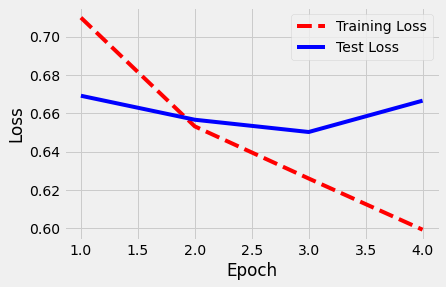

In [61]:
plt.style.use('fivethirtyeight')

# Get training and test loss histories
training_loss = train_history.history['loss']
test_loss = train_history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [62]:
pred = model.predict(test_dataset, verbose=1)

473/473 [==============================] - 41s 86ms/step


In [63]:
# for ensemble
np.save('xlm-roberta', pred)

In [64]:
pred_sentiment = np.argmax(pred, axis=1)

print(pred_sentiment)

[2 2 4 ... 3 4 3]


In [65]:
submission = pd.DataFrame({'review_id': test_df['review_id'],
                           'rating': pred_sentiment})

# Convert rating values back to (1 - 5)

In [66]:
submission['rating'] = submission['rating'].map(rating_mapper_decode)
submission.to_csv('submission.csv', index=False)
submission['rating'].value_counts()

5    22675
4    21225
3    12775
1     3349
2      403
Name: rating, dtype: int64

**Thanks to:**
* indralin/text-processing-augmentation-tpu-baseline-0-4544
* garyongguanjie/eda-sentiment-shopee